In [1]:
import shutil
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import os # folders & files operations
import matplotlib.image as mpimg # image read
import matplotlib.pyplot as plt # image display

In [2]:
import os
import glob

os.chdir(r"C:\Users\vamsh\OneDrive\Desktop\Image Classification\Image Classification")

In [3]:
def train_val_test_split(root_dir=r"C:\Users\vamsh\OneDrive\Desktop\Image Classification\Image Classification" ,
                         processed_dir='Tribe_split',    # source: one subfolder per classprocessed_dir='Tribes.split',   # destination root
                         test_ratio=0.20,           # fraction of total
                         val_ratio=0.10,            # fraction of total
                         seed=42,                   # for reproducibility
                         overwrite=False            # if True, remove existing processed_dir first
                        ):
    print("########### Train / Val / Test Split started ###########")
    assert 0 < test_ratio < 1 and 0 < val_ratio < 1, "ratios must be in (0,1)"
    assert (test_ratio + val_ratio) < 1, "test_ratio + val_ratio must be < 1"

    # Prepare destination
    if overwrite and os.path.exists(processed_dir):
        shutil.rmtree(processed_dir)

    splits = ['train', 'val', 'test']

    # List class folders only
    classes_dir = [d for d in os.listdir(root_dir)
                   if os.path.isdir(os.path.join(root_dir, d))]

    for cls in classes_dir:
        print(f"$$$$$$$ Class Name: {cls} $$$$$$$")

        src = os.path.join(root_dir, cls)

        # All files in class folder (skip hidden)
        allFileNames = [f for f in os.listdir(src)
                        if not f.startswith('.')
                        and os.path.isfile(os.path.join(src, f))]

        if len(allFileNames) == 0:
            print(f"⚠️  No files found in {src}, skipping.")
            continue

        # Reproducible shuffle
        rng = np.random.RandomState(seed)
        allFileNames = rng.permutation(np.array(allFileNames))

        n_total = len(allFileNames)
        n_test = int(n_total * test_ratio)
        n_val  = int(n_total * val_ratio)
        n_train = n_total - n_test - n_val

        # Split indices
        test_files  = allFileNames[:n_test]
        val_files   = allFileNames[n_test:n_test + n_val]
        train_files = allFileNames[n_test + n_val:]

        # Report
        print(f"Total images: {n_total}")
        print(f"Training:    {len(train_files)}")
        print(f"Validation:  {len(val_files)}")
        print(f"Testing:     {len(test_files)}\n")

        # Make destination class dirs
        for sp in splits:
            os.makedirs(os.path.join(processed_dir, sp, cls), exist_ok=True)

        # Helper to copy a list of filenames to a split dir
        def _copy_many(file_list, split_name):
            dst_dir = os.path.join(processed_dir, split_name, cls)
            for name in file_list:
                shutil.copy2(os.path.join(src, name), dst_dir)

        _copy_many(train_files, 'train')
        _copy_many(val_files, 'val')
        _copy_many(test_files, 'test')

In [4]:
train_val_test_split(root_dir=r"C:\Users\vamsh\OneDrive\Desktop\Image Classification\Image Classification", processed_dir='/kaggle/working/CNNData',overwrite=True)

########### Train / Val / Test Split started ###########
$$$$$$$ Class Name: Chenchu $$$$$$$
Total images: 158
Training:    112
Validation:  15
Testing:     31

$$$$$$$ Class Name: Gadaba $$$$$$$
Total images: 192
Training:    135
Validation:  19
Testing:     38

$$$$$$$ Class Name: Gonds $$$$$$$
Total images: 156
Training:    110
Validation:  15
Testing:     31

$$$$$$$ Class Name: Koya $$$$$$$
Total images: 222
Training:    156
Validation:  22
Testing:     44

$$$$$$$ Class Name: Lambada $$$$$$$
Total images: 172
Training:    121
Validation:  17
Testing:     34



In [5]:
# First, install TensorFlow if not already installed
!pip install tensorflow

# Import necessary libraries
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path for train, validation and test datasets
train_path = '/kaggle/working/CNNData/train'
test_path = '/kaggle/working/CNNData/test'

IMAGE_SIZE = [224, 224] #Default image size for VGG16

folders = glob.glob('train/*') # Get number of classes

# ImageDataGenerator can help perform augumentation on existing images. This way, we get more diverse train set.
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Through flow_from_directory - We create an array of images that can be used for training. 
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
validation_set = validation_datagen.flow_from_directory('/kaggle/working/CNNData/val',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 602 images belonging to 5 classes.
Found 82 images belonging to 5 classes.
Found 175 images belonging to 5 classes.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [7]:
# The input is a 224 * 224 RGB image to VGG based convNet
IMAGE_SIZE = [ 224 , 224 , 3 ]

# Load the model 
base_res = ResNet50(include_top = False, input_shape = IMAGE_SIZE, weights = 'imagenet')

In [8]:
# Visualize the model
base_res.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
base_res.trainanable=False

In [10]:
data_dir = r'/kaggle/working/CNNData/train'  # adjust path
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

In [11]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

x = Flatten()(base_res.output) #Output obtained on vgg19 is now flattened. 

prediction = Dense(len(folders), activation='softmax')(x) 

# We have 5 classes, and so, the prediction is being done on len(folders) - 5 classes

# Creating model object 
model = Model(inputs=base_res.input, outputs=prediction)

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,089,477 (91.89 MB)

 Trainable params: 24,036,357 (91.69 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

ES = EarlyStopping(
    monitor='val_loss', # Same as the 
    patience=5, # Wait for 5 epochs before stopping the training
    verbose=1,
    restore_best_weights='True', # Restore model weights from the epoch with the best value of the monitored quantity.
    min_delta=0.1
)

# MC = ModelCheckpoint(
#     '/kaggle/working/SportsImageClassify_Vgg.keras', # We can also provide full path to the folder to save model
#     monitor='val_loss',  # Monitor other things like val_accuracy or accuracy 
#     save_best_only='True', # Make sure to save only the best model
#     verbose=1
# )

In [15]:
print(training_set.class_indices)   # shows mapping {class_name: index}
print("Number of classes:", training_set.num_classes)


{'Chenchu': 0, 'Gadaba': 1, 'Gonds': 2, 'Koya': 3, 'Lambada': 4}
Number of classes: 5


In [16]:
history=model.fit(training_set,validation_data=test_set,epochs=20,callbacks=[ES])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 432s 19s/step - accuracy: 0.4535 - loss: 5.7616 - val_accuracy: 0.2514 - val_loss: 6950.9941
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 430s 23s/step - accuracy: 0.5664 - loss: 3.3935 - val_accuracy: 0.2114 - val_loss: 24856182.0000
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 341s 18s/step - accuracy: 0.5714 - loss: 2.3503 - val_accuracy: 0.1771 - val_loss: 71311280.0000
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 313s 16s/step - accuracy: 0.6047 - loss: 1.2753 - val_accuracy: 0.2114 - val_loss: 1572235.3750
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 425s 23s/step - accuracy: 0.5498 - loss: 3.2019 - val_accuracy: 0.1771 - val_loss: 476476.8438
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 365s 19s/step - accuracy: 0.5664 - loss: 2.3761 - val_accuracy: 0.1771 - val_loss: 266797.1250
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


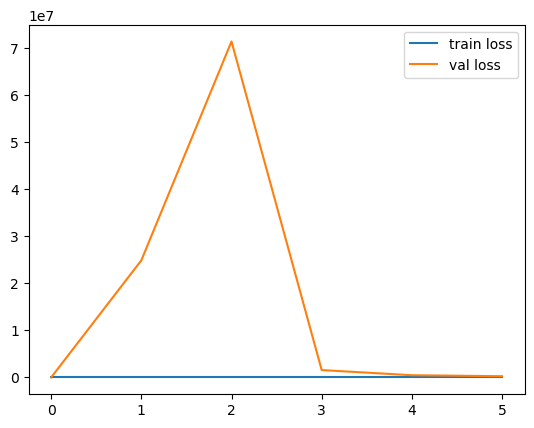

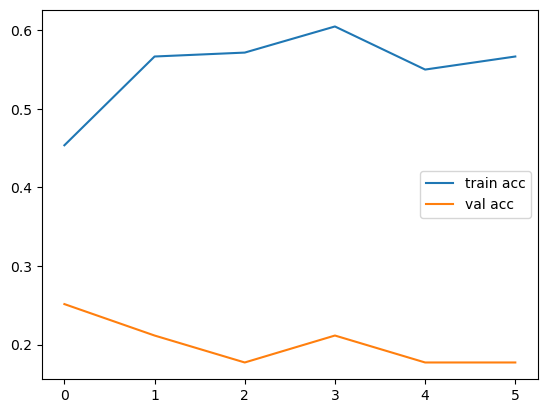

In [17]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [19]:
# First, install the OpenCV library
!pip install opencv-python

# Then import the required libraries
import cv2
import numpy as np

def classify(frame):
    # Converting Image Size to Cnn Input Size
    img = cv2.resize(frame, (224, 224))
    
    # scaling to 0 to 1 range
    if(np.max(img) > 1):
        img = img/255.0
        
    img = np.array([img])
    prediction = model.predict(img)[0]  # will predict 12 classes probabilities
    # Taking Class Names & Numbers for Prediction from train data generator
    classes = {v: k for k, v in training_set.class_indices.items()}
    # mapping high probability class index number with class name
    cls = classes[np.argmax(prediction)] 
    
    return cls  # output class name

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)


In [24]:
import glob

images = glob.glob(r"C:\Users\vamsh\OneDrive\Desktop\Image Classification\Image Classification\Gonds\6ed62b95-3df4-4d70-995c-ef2963006ebc.jpg")

images

['C:\\Users\\vamsh\\OneDrive\\Desktop\\Image Classification\\Image Classification\\Gonds\\6ed62b95-3df4-4d70-995c-ef2963006ebc.jpg']

Given Image:



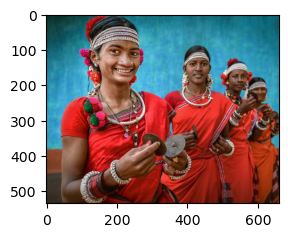


Original Class: C:\Users\vamsh\OneDrive\Desktop\Image Classification\Image Classification\Gonds\6ed62b95-3df4-4d70-995c-ef2963006ebc
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction Class: Koya



In [25]:
# Looping through each image and applying classify function
import matplotlib.image as mpimg

for img in images:
    # Reading image
    image = mpimg.imread(r'{}'.format(img))
    print("Given Image:")
    print()
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.show()
    print()
    print("Original Class:",img.split("/")[-1].split(".")[0])
    out = classify(image) # prediction function
    print("Prediction Class:",out.title())
    print()
    print("=================================================================")